<img align="right" width="250" height="150" src="https://lh3.googleusercontent.com/p/AF1QipPWZQfa087JiVjutpUTVEGRnh6W214Wjm439gKQ=w1080-h608-p-no-v0">

# **Proyecto:**

### **Retención de usuarios de la Plataforma Digital**

### Obtención de medidas descriptivas de los distintos archivos obtenidos y curados

## Importación de librerias y datos globales

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

try:
    # Monto la unidad de drive porque los archivos son muy grandes
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = '/content/drive/MyDrive/Trayecto3-DataDriven/Data/'
except:
    # Sino lo consigo asumo que estoy trabajando local
    DIR = os.path.abspath(r'..\Data\Export') + '\\'

## ANALISIS EXPLORATORIO DE DATOS

### Actividades

Basándose en los pasos vistos en EDA, investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción  de abandono de cliente.

Justificar cada columna no seleccionada. Intente conservar variables de distinto tipo (**Revisar/Ver**)

* Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes o con significados similares.
* Eliminar los valores extremos que no sean relevantes para la predicción. (O el objetivo que se ha planteado) (**Revisar/Ver**)
* Realizar un completo análisis (EDA) y documentar la información que resulte relevate para reportar, considerando el objetivo planteado.

## Archivo de usuarios

In [2]:
file = DIR + 'Usuarios.csv'

df_usuarios = pd.read_csv(file, encoding='latin-1', parse_dates=["FechaCreacion", "LAST_LOGIN"])
df_usuarios["SegFactor"] = df_usuarios["SegFactor"].str.strip()
df_usuarios.sample(5)

,ID_USER,FechaCreacion,LAST_LOGIN,SegFactor
769175,a0757e24c0c943579411c5fae345600e,2019-10-11,2022-06-05,SMS
557881,a979eb0d4d4a4e989f01237989ebca2f,2020-02-06,2022-06-03,Softoken
272172,b09bd1053fd24997b9b6ec2650721142,2022-05-18,2022-05-18,Softoken
520893,b15e3cb20c8642cf9d5a2243c7eeeebc,2021-11-12,2022-06-03,Softoken
807086,fad904354271406ba66e85d70eb7a798,2019-04-14,2022-06-05,SMS


In [3]:
# Corroboro que sea un Dataset
print("Tipo de estrucura de datos de usuarios", type(df_usuarios), "\n")

# Identifico la cantidad de filas y columnas que tiene mi Dataset de usuarios
print("Dimensión dataframe", df_usuarios.shape)

Tipo de estrucura de datos de usuarios <class 'pandas.core.frame.DataFrame'> 

Dimensión dataframe (903291, 4)


In [4]:
# Informacion sintetizada del Data Frame Usuarios de plataforma
df_usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903291 entries, 0 to 903290
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID_USER        903291 non-null  object        
 1   FechaCreacion  903291 non-null  datetime64[ns]
 2   LAST_LOGIN     903291 non-null  datetime64[ns]
 3   SegFactor      903291 non-null  object        
dtypes: datetime64[ns](2), object(2)
memory usage: 27.6+ MB


In [5]:
# Detección las variables con datos faltantes de usuarios
missing_values_count = df_usuarios.isna().sum()
print(missing_values_count, '\n') 
print(missing_values_count / df_usuarios.shape[0]*100)

ID_USER          0
FechaCreacion    0
LAST_LOGIN       0
SegFactor        0
dtype: int64 

ID_USER          0.0
FechaCreacion    0.0
LAST_LOGIN       0.0
SegFactor        0.0
dtype: float64


In [6]:
# Valores unicos de la unica variable categórica que tiene este archivo
print(f'SegFactor:', df_usuarios['SegFactor'].unique())

SegFactor: ['SMS' 'No tiene segundo factor' 'Softoken']


In [7]:
# Filtro los registros que se crearon hace menos de tres meses ya que todos ellos no se pueden evaluar
df_usuarios = df_usuarios[df_usuarios['FechaCreacion'] < dt.datetime(2022, 2, 1)]

In [8]:
fecha_corte =  dt.datetime(2022, 4, 30)
df_usuarios[df_usuarios['LAST_LOGIN'] > fecha_corte] = fecha_corte

# Calculo la cantidad de dias desde su último acceso a la plataforma 
df_usuarios['DIAS_SIN_USAR_PD'] = (fecha_corte - df_usuarios['LAST_LOGIN']).astype('timedelta64[D]')
# Pongo a 0 los cálculos negativos debido a que puede haber registros posteriores al 30/04/2022
#df_usuarios['DIAS_SIN_USAR_PD'] = np.where(df_usuarios['DIAS_SIN_USAR_PD'] > 0, df_usuarios['DIAS_SIN_USAR_PD'], 0)

# Calculo Antiguedad en dias la plataforma
df_usuarios['ANTIGUEDAD_PD'] = (df_usuarios['LAST_LOGIN'] - df_usuarios['FechaCreacion']).astype('timedelta64[D]')
# Filtro los registros sin antiguedad en la plataforma
df_usuarios = df_usuarios.loc[df_usuarios['ANTIGUEDAD_PD'] > 0]
df_usuarios.sample(5)

,ID_USER,FechaCreacion,LAST_LOGIN,SegFactor,DIAS_SIN_USAR_PD,ANTIGUEDAD_PD
12246,dfb95f871c694baa97b2f8a543f38c68,2019-12-19,2020-01-31,SMS,820.0,43.0
79820,1c39d10cc45e432d98182f2767890e5c,2020-03-06,2021-01-18,SMS,467.0,318.0
22866,d43b302878134afb9c5bf55dac9f7b5e,2020-03-30,2020-05-21,SMS,709.0,52.0
162230,b4e959223040416eabefcd1cb1304f3e,2021-10-06,2022-01-09,No tiene segundo factor,111.0,95.0
59808,6c33b0cd0a34493f96666784ec53cdb6,2020-09-07,2020-10-12,SMS,565.0,35.0


In [9]:
# Asumo que abandonó la PD si lleva mas de 90 dias sin hacer login
df_usuarios["ABANDONO_PD"] = ['Sí' if ( _ > 90 ) else 'No' for _ in df_usuarios["DIAS_SIN_USAR_PD"]]
df_usuarios.sample(5)

,ID_USER,FechaCreacion,LAST_LOGIN,SegFactor,DIAS_SIN_USAR_PD,ANTIGUEDAD_PD,ABANDONO_PD
81742,7ec1fad593274deda8b390a0d7777557,2021-01-20,2021-01-26,SMS,459.0,6.0,Sí
58390,d7f3a3102b5f467b845f4251b8806b1d,2020-06-17,2020-10-06,SMS,571.0,111.0,Sí
59443,bc39bf6c1c994a7db89fadc15d990463,2020-09-01,2020-10-09,SMS,568.0,38.0,Sí
155213,fea3b84103c34826a4bd2c482b3d634a,2021-12-10,2021-12-14,No tiene segundo factor,137.0,4.0,Sí
82660,135a6e2d26c749f09cd72745c2d823b0,2020-06-11,2021-01-31,SMS,454.0,234.0,Sí


### Medidas descriptivas

In [10]:
df_usuarios[['DIAS_SIN_USAR_PD', 'ANTIGUEDAD_PD']].describe().round()

,DIAS_SIN_USAR_PD,ANTIGUEDAD_PD
count,181164.0,181164.0
mean,320.0,335.0
std,255.0,280.0
min,0.0,1.0
25%,86.0,88.0
50%,270.0,269.0
75%,540.0,551.0
max,1231.0,1236.0


### Medidas de posición

#### Distribución de cuantos días transcurrieron desde la fecha de último movimiento para el conjunto de persona que hicieron el onboarding en la plataforma digital

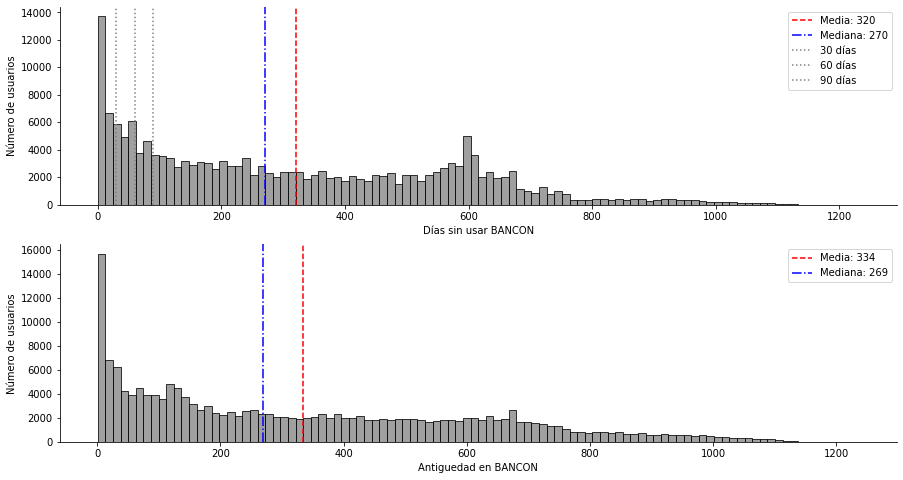

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 8))
bins = 100

media = df_usuarios['DIAS_SIN_USAR_PD'].mean()
mediana = df_usuarios['DIAS_SIN_USAR_PD'].median()
sns.histplot(df_usuarios['DIAS_SIN_USAR_PD'], bins=bins, ax=ax[0], color='gray')
ax[0].axvline(media, color='red', linestyle='--', label='Media: {}'.format(int(media)))
ax[0].axvline(mediana, color='blue', linestyle='-.', label='Mediana: {}'.format(int(mediana)))

ax[0].axvline(30, color='grey', linestyle=':', label='30 días')
ax[0].axvline(60, color='grey', linestyle=':', label='60 días')
ax[0].axvline(90, color='grey', linestyle=':', label='90 días')

ax[0].set_xlabel('Días sin usar BANCON')
ax[0].set_ylabel('Número de usuarios')
ax[0].legend()

media = df_usuarios['ANTIGUEDAD_PD'].mean()
mediana = df_usuarios['ANTIGUEDAD_PD'].median()
sns.histplot(df_usuarios['ANTIGUEDAD_PD'], bins=bins, ax=ax[1], color='gray')
ax[1].axvline(media, color='red', linestyle='--', label='Media: {}'.format(int(media)))
ax[1].axvline(mediana, color='blue', linestyle='-.', label='Mediana: {}'.format(int(mediana)))
ax[1].set_xlabel('Antiguedad en BANCON')
ax[1].set_ylabel('Número de usuarios')
ax[1].legend()

sns.despine()

#### Distribución de cuantos días transcurrieron desde la fecha de último movimiento para el conjunto de las personas que son consideradas usuarios de la plataforma digital

<AxesSubplot:xlabel='DIAS_SIN_USAR_PD', ylabel='Count'>

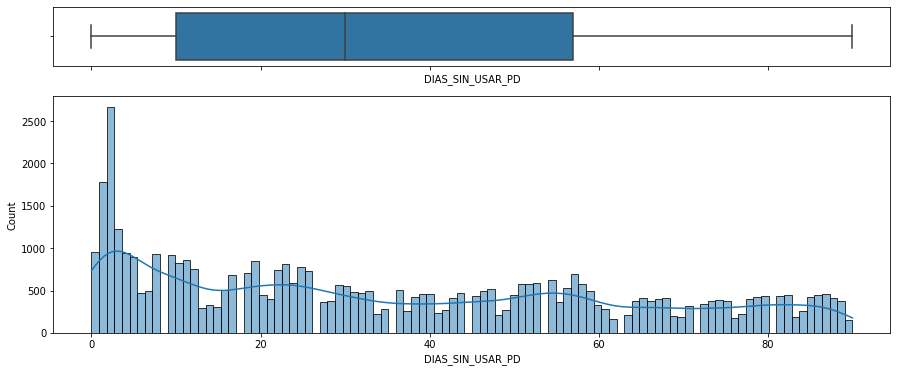

In [12]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 6), sharex=True, gridspec_kw={"height_ratios": (.2, .8)})
sns.boxplot(data=df_usuarios[df_usuarios['ABANDONO_PD']=='No'], x='DIAS_SIN_USAR_PD', ax=ax[0])
sns.histplot(df_usuarios[df_usuarios['ABANDONO_PD']=='No'], x='DIAS_SIN_USAR_PD', ax=ax[1], bins=bins, kde=True)
#sns.boxplot(data=df_usuarios, x='ANTIGUEDAD_PD', ax=ax[2])
#sns.histplot(df_usuarios['ANTIGUEDAD_PD'], ax=ax[3], bins=bins, kde=True, stat='density')

### Medidas de dispersión

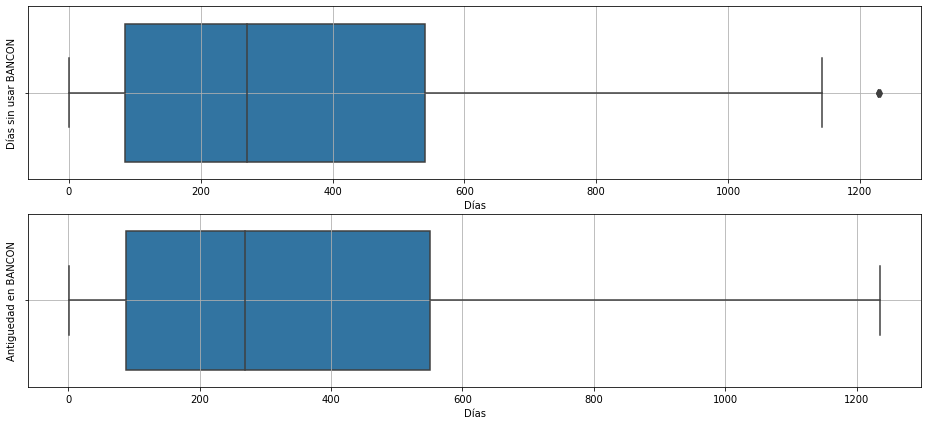

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 7))

sns.boxplot(x='DIAS_SIN_USAR_PD', data=df_usuarios, ax=axes[0])
axes[0].set_ylabel('Días sin usar BANCON')
axes[0].set_xlabel('Días')
axes[0].grid(True)

sns.boxplot(x='ANTIGUEDAD_PD', data=df_usuarios, ax=axes[1])
axes[1].set_ylabel('Antiguedad en BANCON')
axes[1].set_xlabel('Días')
axes[1].grid(True)

plt.show()

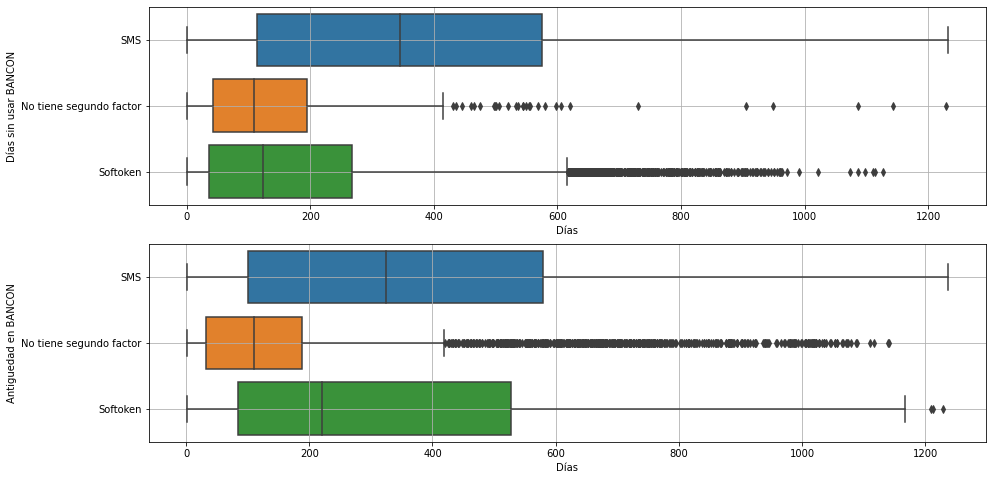

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))

sns.boxplot(x='DIAS_SIN_USAR_PD', y='SegFactor', data=df_usuarios, ax=axes[0])
axes[0].set_ylabel('Días sin usar BANCON')
axes[0].set_xlabel('Días')
axes[0].grid(True)

sns.boxplot(x='ANTIGUEDAD_PD', y='SegFactor', data=df_usuarios, ax=axes[1])
axes[1].set_ylabel('Antiguedad en BANCON')
axes[1].set_xlabel('Días')
axes[1].grid(True)

plt.show()

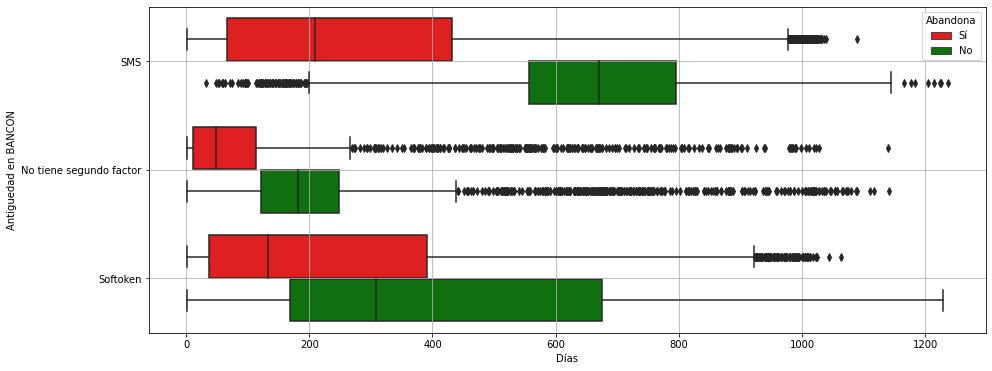

In [15]:
graph_colors = ['Red', 'Green']
graph_labels = ['No', 'Si']

ax = plt.figure(figsize=(15, 6))
ax = sns.boxplot(x='ANTIGUEDAD_PD', y='SegFactor', hue='ABANDONO_PD', data=df_usuarios, palette=['Red', 'Green'])
ax.set_ylabel('Antiguedad en BANCON')
ax.set_xlabel('Días')
ax.grid(True)

plt.legend(title='Abandona', loc='best') #, labels=graph_labels)

plt.show()

In [16]:
count_abandono = df_usuarios["ABANDONO_PD"].value_counts()
count_abandono

Sí    134140
No     47024
Name: ABANDONO_PD, dtype: int64

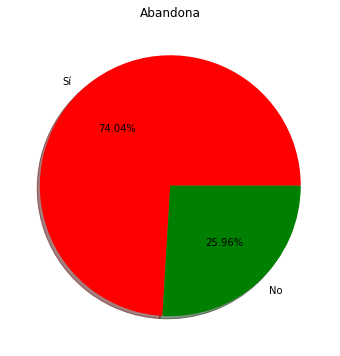

In [17]:
graph_colors = ['red', 'green']
graph_labels = ['Sí', 'No']
ax = plt.figure(figsize=(6, 6))
plt.pie(count_abandono, autopct='%1.2f%%', shadow=True, colors=graph_colors, labels=graph_labels)
plt.title('Abandona')
plt.show()

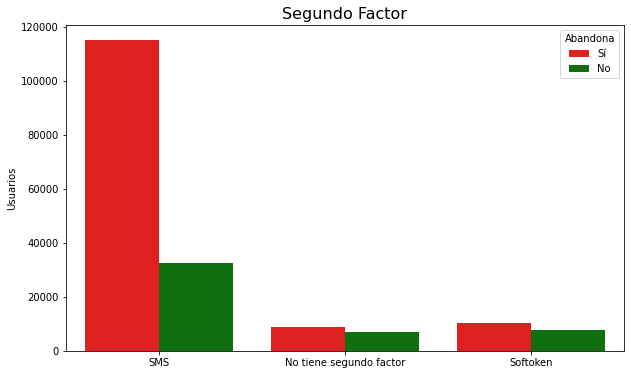

In [18]:
# Grafico el abandono según todas las variables
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_usuarios, x="SegFactor", hue=df_usuarios["ABANDONO_PD"], palette=graph_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Usuarios')
ax.set_title('Segundo Factor', fontsize=16)
plt.legend(title='Abandona', loc='best') #, labels=graph_labels
plt.show()

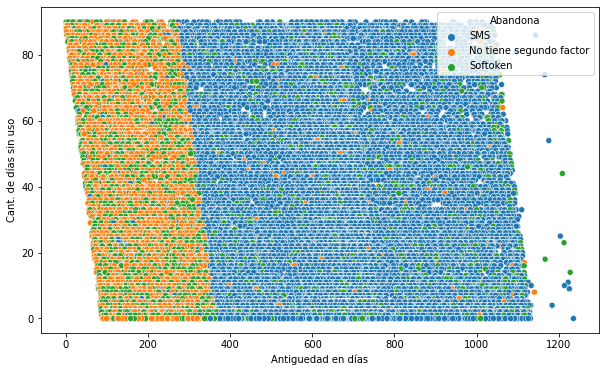

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=df_usuarios[df_usuarios['ABANDONO_PD']=='No'], y='DIAS_SIN_USAR_PD', x='ANTIGUEDAD_PD', hue=df_usuarios['SegFactor'])
ax.legend(title='Abandona')
ax.set_xlabel('Antiguedad en días')
ax.set_ylabel('Cant. de días sin uso')
plt.legend(title='Abandona', loc='best')
plt.show()

## Archivo de Crosseling

### Importación

In [20]:
tcols = {
  'PERIODO': str,
  'ID_USER': str,
  'RELACION': str,
  'TIPOIMPN': str,
  'NATUJURI': str,
  'SUCURSAL': str,
  'BCRASECT': str,
  'BCRASEGO': str,
  'GRUPO_CLIENTE': str,
  'GRUPOGENERAL': str,
  'SUBGRUPO': str,
  'SEGMENTO_SUELDOS': str,
  'SEGMENTO_BANCAS': str,
  'SALDO_COMPUTO_SIST_2': float,
  'SALDO_COMPUTO_SIST_CC_MB': float,
  'SALDO_COMPUTO_SIST_CA_P': float,
  'SALDO_COMPUTO_SIST_CC_P': float,
  'SALDO_COMPUTO_SIST_FCI': float,
  'FUM': str
}

file = DIR + 'crosseling_202204.csv'
df_crosseling = pd.read_csv(file, dtype=tcols, parse_dates=['FUM'], index_col=False)

In [21]:
# Corroboro que sea un Dataset
print("Tipo de estructura de datos de productos", type(df_crosseling), "\n")

# Identifico la cantidad de filas y columnas que tiene mi Dataset Telefonia
print("Dimensión dataframe", df_crosseling.shape)

Tipo de estructura de datos de productos <class 'pandas.core.frame.DataFrame'> 

Dimensión dataframe (885787, 35)


### Medidas descriptivas

In [22]:
# Informacion sintetizada del Data Frame Crosseling
df_crosseling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885787 entries, 0 to 885786
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ID_USER                   885787 non-null  object        
 1   RELACION                  885787 non-null  object        
 2   TIPOIMPN                  885787 non-null  object        
 3   NATUJURI                  885787 non-null  object        
 4   SUCURSAL                  885787 non-null  object        
 5   BCRASECT                  885786 non-null  object        
 6   BCRASEGO                  885787 non-null  object        
 7   GRUPO_CLIENTE             885787 non-null  object        
 8   GRUPOGENERAL              885787 non-null  object        
 9   SUBGRUPO                  885787 non-null  object        
 10  SEGMENTO_SUELDOS          885787 non-null  object        
 11  FUM                       885787 non-null  datetime64[ns]
 12  ES

In [23]:
# Detección las variables con datos faltantes de crosseling
missing_values_count = df_crosseling.isna().sum()
print(missing_values_count) 
print(missing_values_count / df_crosseling.shape[0]*100)

ID_USER                     0
RELACION                    0
TIPOIMPN                    0
NATUJURI                    0
SUCURSAL                    0
BCRASECT                    1
BCRASEGO                    0
GRUPO_CLIENTE               0
GRUPOGENERAL                0
SUBGRUPO                    0
SEGMENTO_SUELDOS            0
FUM                         0
ES_CAPITA                   0
CL_ACTIVO_FUM               0
TIENE_I_CA_D                0
TIENE_I_CA_P                0
TIENE_I_CBESA               0
TIENE_I_CC                  0
TIENE_I_CCAD                0
TIENE_I_CS                  0
TIENE_I_FCI                 0
TIENE_I_PF                  0
TIENE_I_PR_HIP              0
TIENE_I_PR_PERS             0
TIENE_I_PREP                0
TIENE_I_SE_PATR             0
TIENE_I_SEG_VIDA            0
TIENE_I_VISA                0
TIENE_I_TJ_SOC              0
SALDO_COMPUTO_SIST_2        0
SALDO_COMPUTO_SIST_CC_MB    0
SALDO_COMPUTO_SIST_CA_P     0
SALDO_COMPUTO_SIST_CC_P     0
SALDO_COMP

### Cruce de tablas de Usuarios de platadorma y Crosseling

El propósito de esta operación es obtener una sola tabla resumida con todos los datos de ambas tablas y que podamos calcular con facilidad la columna de dias de no uso de la plataforma.

In [24]:
df_estudio = pd.merge(df_usuarios[['ID_USER', 'ABANDONO_PD']], df_crosseling, how='inner', on = 'ID_USER')

In [25]:
# Solo me quedo con los 'Individuo sin actividad comercial'
df_estudio = df_estudio.loc[df_estudio['GRUPOGENERAL'] == 'Individuo sin actividad comercial']
df_estudio.drop('GRUPOGENERAL', axis=1, inplace=True)

In [26]:
# Calculo el saldo total como la suma de todas las columnas de saldo (**Revisar luego como utilizamos este dato**)
df_estudio["SALDO_TOTAL"] = df_estudio["SALDO_COMPUTO_SIST_2"] + \
    df_estudio["SALDO_COMPUTO_SIST_CC_MB"] + \
    df_estudio["SALDO_COMPUTO_SIST_CA_P"] + \
    df_estudio["SALDO_COMPUTO_SIST_CC_P"] + \
    df_estudio["SALDO_COMPUTO_SIST_FCI"]

delCols = ["SALDO_COMPUTO_SIST_2", "SALDO_COMPUTO_SIST_CC_MB", "SALDO_COMPUTO_SIST_CA_P", "SALDO_COMPUTO_SIST_CC_P", "SALDO_COMPUTO_SIST_FCI"]
df_estudio.drop(delCols, axis=1, inplace=True)

In [27]:
df_crosseling.head()

,ID_USER,RELACION,TIPOIMPN,NATUJURI,SUCURSAL,BCRASECT,BCRASEGO,GRUPO_CLIENTE,GRUPOGENERAL,SUBGRUPO,...,TIENE_I_SE_PATR,TIENE_I_SEG_VIDA,TIENE_I_VISA,TIENE_I_TJ_SOC,SALDO_COMPUTO_SIST_2,SALDO_COMPUTO_SIST_CC_MB,SALDO_COMPUTO_SIST_CA_P,SALDO_COMPUTO_SIST_CC_P,SALDO_COMPUTO_SIST_FCI,CROSS_IND
0,35877ee96af848feb248583f83533beb,TIT,5,27,902,PRIV,0,I8,Individuo sin actividad comercial,Público General,...,0,0,0,0,0.00,0.0,0.59,0.0,0.0,2
1,c7dc018227a0492aab2c718dc61da7e4,TIT,5,27,915,PRIV,0,I8,Individuo sin actividad comercial,Público General,...,0,0,0,0,0.00,0.0,8009.74,0.0,0.0,1
2,175e8eab69a741a18536306ca844e046,TIT,5,27,101,PRIV,0,I4,Individuo sin actividad comercial,Sueldo,...,0,0,1,0,930333.33,0.0,50976.61,0.0,0.0,6
3,63357127436e43c1b43e87d0e459129c,TIT,5,27,900,PRIV,0,I8,Individuo sin actividad comercial,Público General,...,0,0,0,0,0.00,0.0,0.00,0.0,0.0,1
4,f36664d00390434b8fe1e21df37edeb2,TIT,5,27,924,PRIV,0,I4,Individuo sin actividad comercial,Sueldo,...,0,0,0,0,0.00,0.0,822618.58,0.0,0.0,2


### Variables Categoricas

In [28]:
# Valores unicos
var_cat = ['GRUPO_CLIENTE', 'SUBGRUPO', 'SEGMENTO_SUELDOS']
for i in var_cat:
  print(f'{i}:', df_estudio[i].unique(), '\n')

GRUPO_CLIENTE: ['I8' 'I4' 'I6' 'I7'] 

SUBGRUPO: ['Público General' 'Sueldo' 'Con producto  Social'] 

SEGMENTO_SUELDOS: ['OTROS' 'SUELDO PRIVADOS' 'SUELDO BANCOR' 'SUELDO ADM PUBL M4'
 'SUELDO ADM PUBL RESTO' 'JUBILADOS ANSES' 'JUBILADOS PROVINCIA'
 'JUBILADOS OTROS'] 



In [29]:
df_estudio[['GRUPO_CLIENTE', 'SUBGRUPO', 'SEGMENTO_SUELDOS']].drop_duplicates().sort_values(['GRUPO_CLIENTE', 'SUBGRUPO', 'SEGMENTO_SUELDOS'])

,GRUPO_CLIENTE,SUBGRUPO,SEGMENTO_SUELDOS
14,I4,Sueldo,JUBILADOS ANSES
416,I4,Sueldo,JUBILADOS OTROS
30,I4,Sueldo,JUBILADOS PROVINCIA
18,I4,Sueldo,OTROS
8,I4,Sueldo,SUELDO ADM PUBL M4
11,I4,Sueldo,SUELDO ADM PUBL RESTO
5,I4,Sueldo,SUELDO BANCOR
1,I4,Sueldo,SUELDO PRIVADOS
177,I6,Con producto Social,JUBILADOS ANSES
7,I6,Con producto Social,OTROS


In [30]:
# Agrupo lo que son jubilados y Sueldos de la administrción pública
df_estudio.loc[df_estudio['SEGMENTO_SUELDOS'].str[0:9] == 'JUBILADOS', 'SEGMENTO_SUELDOS'] = 'JUBILADOS'
df_estudio.loc[df_estudio['SEGMENTO_SUELDOS'].str[0:15] == 'SUELDO ADM PUBL', 'SEGMENTO_SUELDOS'] = 'SUELDO ADM PUBL'
df_estudio[['GRUPO_CLIENTE', 'SUBGRUPO', 'SEGMENTO_SUELDOS']].drop_duplicates().sort_values(['GRUPO_CLIENTE', 'SUBGRUPO', 'SEGMENTO_SUELDOS'])

,GRUPO_CLIENTE,SUBGRUPO,SEGMENTO_SUELDOS
14,I4,Sueldo,JUBILADOS
18,I4,Sueldo,OTROS
8,I4,Sueldo,SUELDO ADM PUBL
5,I4,Sueldo,SUELDO BANCOR
1,I4,Sueldo,SUELDO PRIVADOS
177,I6,Con producto Social,JUBILADOS
7,I6,Con producto Social,OTROS
166,I6,Con producto Social,SUELDO ADM PUBL
89,I6,Con producto Social,SUELDO PRIVADOS
13010,I7,Público General,JUBILADOS


In [31]:
# Frecuencias Relativas
for i in var_cat:
  print(pd.value_counts(df_estudio[i]) / len(df_estudio[i]), '\n')

I8    0.518254
I4    0.303627
I6    0.177483
I7    0.000637
Name: GRUPO_CLIENTE, dtype: float64 

Público General         0.518890
Sueldo                  0.303627
Con producto  Social    0.177483
Name: SUBGRUPO, dtype: float64 

OTROS              0.580471
JUBILADOS          0.257930
SUELDO ADM PUBL    0.086593
SUELDO PRIVADOS    0.074925
SUELDO BANCOR      0.000080
Name: SEGMENTO_SUELDOS, dtype: float64 



[Text(0, 0, 'OTROS'),
 Text(1, 0, 'SUELDO PRIVADOS'),
 Text(2, 0, 'SUELDO BANCOR'),
 Text(3, 0, 'SUELDO ADM PUBL'),
 Text(4, 0, 'JUBILADOS')]

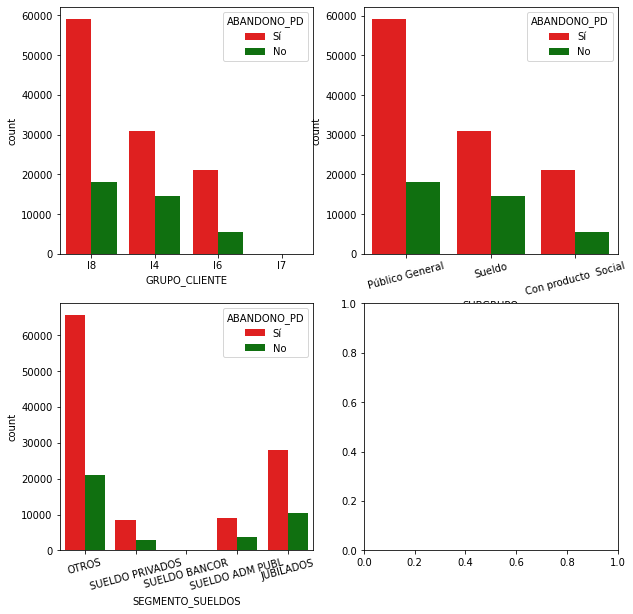

In [32]:
# Grafico el abandono según todas las variables
colors = ['Red', 'Green']
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(data=df_estudio, x="GRUPO_CLIENTE", ax=axs[0,0], hue=df_estudio["ABANDONO_PD"], palette=colors)
ax = sns.countplot(data=df_estudio, x="SUBGRUPO", ax=axs[0,1], hue=df_estudio["ABANDONO_PD"], palette=colors)
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
ax = sns.countplot(data=df_estudio, x="SEGMENTO_SUELDOS", ax=axs[1,0], hue=df_estudio["ABANDONO_PD"], palette=colors)
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
#ax = sns.countplot(data=df_estudio, x="SEG_FACTOR", ax=axs[1,1], hue=df_estudio["ABANDONO_PD"], palette=colors)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
#fig.suptitle('Variables relacionadas al cliente', fontsize=16)

Text(0.5, 0.98, 'Variables normalizadas relacionadas al cliente')

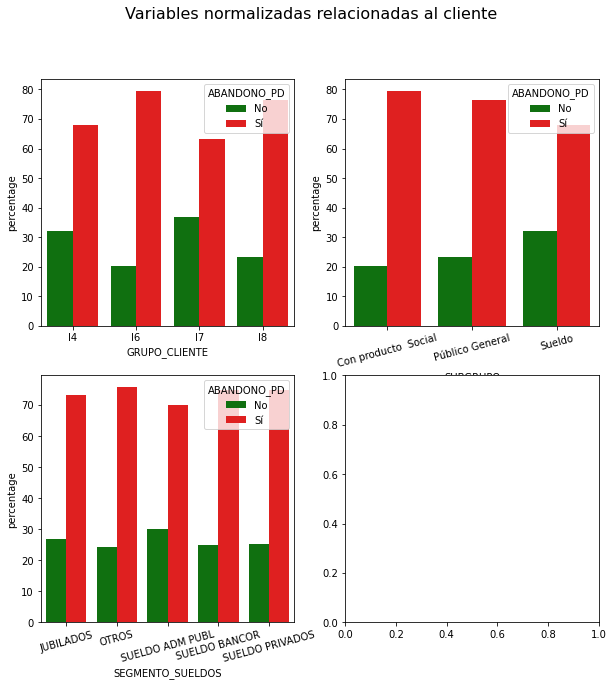

In [33]:
# Grafico el abandono según todas las variables normalizadas
colors = ['Green', 'Red']
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

counts_gc = (df_estudio.groupby(["GRUPO_CLIENTE"])["ABANDONO_PD"]
                     .value_counts(normalize=True)
                     .rename("percentage")
                     .mul(100)
                     .reset_index()
                     .sort_values("ABANDONO_PD"))
ax = sns.barplot(data=counts_gc, x="GRUPO_CLIENTE", y="percentage", ax=axs[0,0], hue="ABANDONO_PD", palette=colors)

counts_sg = (df_estudio.groupby(["SUBGRUPO"])["ABANDONO_PD"]
                     .value_counts(normalize=True)
                     .rename("percentage")
                     .mul(100)
                     .reset_index()
                     .sort_values("ABANDONO_PD"))
ax = sns.barplot(data=counts_sg, x="SUBGRUPO", y="percentage", ax=axs[0,1], hue="ABANDONO_PD", palette=colors)
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

counts_sd = (df_estudio.groupby(["SEGMENTO_SUELDOS"])["ABANDONO_PD"]
                     .value_counts(normalize=True)
                     .rename("percentage")
                     .mul(100)
                     .reset_index()
                     .sort_values("ABANDONO_PD"))
ax = sns.barplot(data=counts_sd, x="SEGMENTO_SUELDOS", y="percentage", ax=axs[1,0], hue="ABANDONO_PD", palette=colors)
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

#counts_sf = (df_estudio.groupby(["SEG_FACTOR"])["ABANDONO_PD"]
#                     .value_counts(normalize=True)
#                     .rename("percentage")
#                     .mul(100)
#                     .reset_index()
#                     .sort_values("ABANDONO_PD"))
#ax = sns.barplot(data=counts_sf, x="SEG_FACTOR", y="percentage", ax=axs[1,1], hue="ABANDONO_PD", palette=colors)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

fig.suptitle('Variables normalizadas relacionadas al cliente', fontsize=16)

In [34]:
df_estudio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149203 entries, 0 to 176633
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_USER           149203 non-null  object        
 1   ABANDONO_PD       149203 non-null  object        
 2   RELACION          149203 non-null  object        
 3   TIPOIMPN          149203 non-null  object        
 4   NATUJURI          149203 non-null  object        
 5   SUCURSAL          149203 non-null  object        
 6   BCRASECT          149203 non-null  object        
 7   BCRASEGO          149203 non-null  object        
 8   GRUPO_CLIENTE     149203 non-null  object        
 9   SUBGRUPO          149203 non-null  object        
 10  SEGMENTO_SUELDOS  149203 non-null  object        
 11  FUM               149203 non-null  datetime64[ns]
 12  ES_CAPITA         149203 non-null  int64         
 13  CL_ACTIVO_FUM     149203 non-null  int64         
 14  TIEN

### Modelo predictivo de análisis por el discriminante

In [35]:
import statsmodels.api as sm

In [36]:
# Comprobar que columnas se incluyen
# Excluir la columna 29 ya que al ser suma de las variables dicotómicas va a introducir sesgo
#r = list(range(12,29)) + list(range(30, 31))
# Como alternativa exlcluir todas las variables dicotomicas e incluir el crossind que es la suma de todas ellas
r = list(range(12,14)) + list(range(29, 31))
df_estudio.iloc[:, r]

,ES_CAPITA,CL_ACTIVO_FUM,CROSS_IND,SALDO_TOTAL
0,0,0,1,0.00
1,1,1,2,822618.58
2,0,0,2,0.66
5,1,1,5,1209.82
7,0,1,1,83.22
...,...,...,...,...
176628,1,1,4,705470.11
176630,0,1,1,0.00
176631,0,1,1,0.00
176632,0,1,1,2485.80


In [37]:
import sklearn
sklearn.__version__
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X = df_estudio.iloc[:, r].values 
y = df_estudio.iloc[:, 1].values

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
LinearDiscriminantAnalysis()
y_pred=clf.predict(X)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [40]:
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

[[    7  7747]
 [    9 22078]]
Accuracy0.7400891391039174


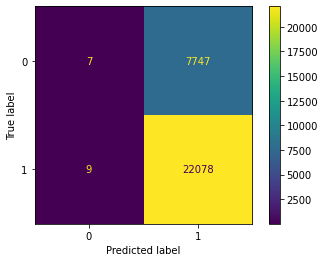

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Reducción de variables por PCA

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [44]:
# Se divide la matriz del dataset en dos partes

X = df_estudio.iloc[:, r].values
# la submatriz x contiene los valores de las primeras 4 columnas del dataframe y todas las filas

y = df_estudio.iloc[:,1].values
# El vector y contiene los valores de la 4 columna (especie)para todas las filas

In [45]:
#Aplicamos una transformación de los datos para poder aplicar las propiedades de la distribución normal

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [46]:
# Calculamos la matriz de covarianza

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[1.0000067  0.5044149  0.64167273 0.1666783 ]
 [0.5044149  1.0000067  0.37760294 0.11166022]
 [0.64167273 0.37760294 1.0000067  0.17678665]
 [0.1666783  0.11166022 0.17678665 1.0000067 ]]


In [47]:
#Calculamos los autovalores y autovectores de la matriz y los mostramos

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.60534614  0.76115201 -0.13459121  0.1899707 ]
 [ 0.50266892 -0.23652584 -0.21172289 -0.80408513]
 [ 0.5698804  -0.60383215 -0.07156644  0.55272173]
 [ 0.23688885  0.00948065  0.96536877 -0.10888949]]

Eigenvalues 
[2.08816864 0.33628966 0.93917352 0.63639498]


In [48]:
#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
2.088168644012833
0.9391735240430102
0.6363949823654906
0.33628965887076395


In [49]:
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

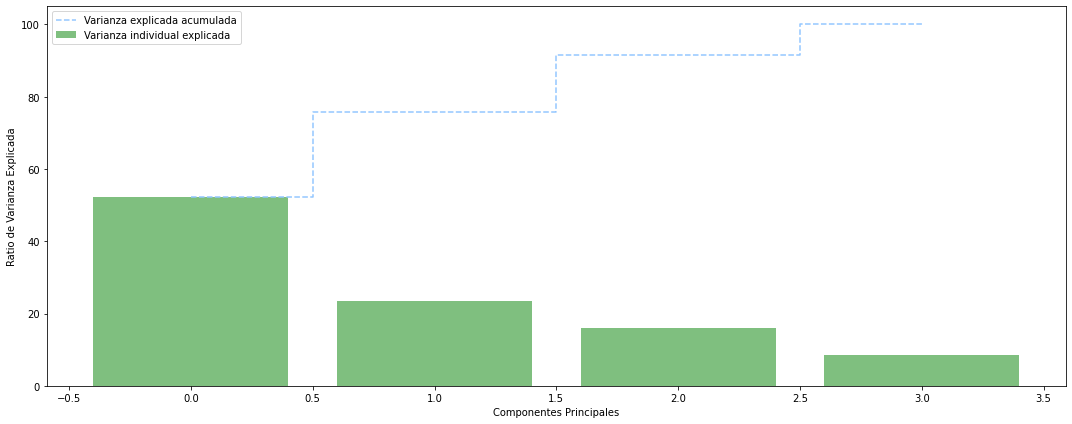

In [50]:
# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(15, 6))

    plt.bar(range(len(eig_pairs)), var_exp, alpha=0.5, align='center',
            label='Varianza individual explicada', color='g')
    plt.step(range(len(eig_pairs)), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout()

In [51]:
#Generamos la matríz a partir de los pares autovalor-autovector
matrix_w = np.hstack((eig_pairs[0][1].reshape(len(eig_pairs),1),
                      eig_pairs[1][1].reshape(len(eig_pairs),1),
                      eig_pairs[2][1].reshape(len(eig_pairs),1)))

print('Matriz W:\n', matrix_w)

Y = X_std.dot(matrix_w)

Matriz W:
 [[ 0.60534614 -0.13459121  0.1899707 ]
 [ 0.50266892 -0.21172289 -0.80408513]
 [ 0.5698804  -0.07156644  0.55272173]
 [ 0.23688885  0.96536877 -0.10888949]]


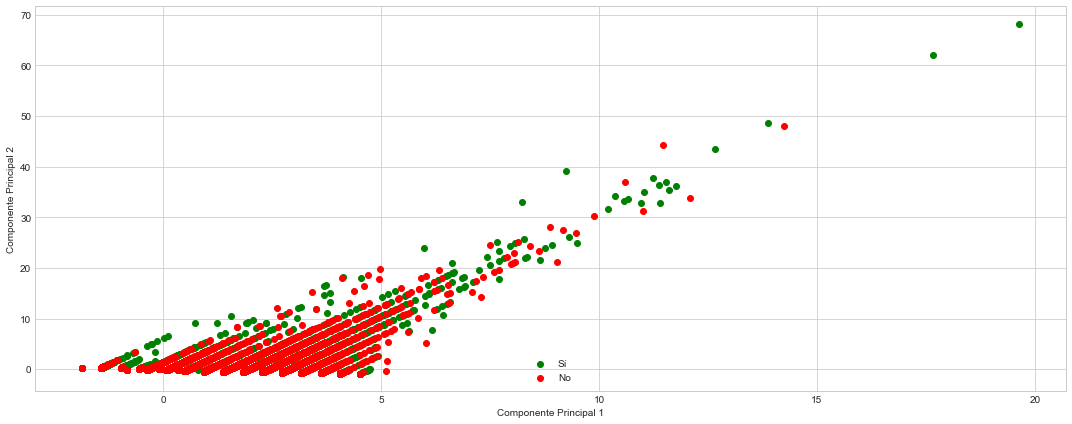

In [52]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15, 6))
    for lab, col in zip(('Sí', 'No'),
                        ('green', 'red')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()  

## Archivo de movimientos

El objeto de leer el archivo de movimientos es incorporar a la tabla de crosseling nuevas columnas con información de:

- Cantidad de movimientos monetarios y monto total realizados por medio de la plataforma digital
- Cantidad de movimientos monetarios y monto total realizados por FUERA de la plataforma digital
- Cantidad de movimientos NO monetarios y realizados por medio de la plataforma digital
- Cantidad de movimientos NO monetarios y realizados por FUERA de la plataforma digital

Total **6** Campos

La idea es tener es que el algoritmo de predicción elegido tenga información adicional para poder inferir si el cliente abandona o no la plataforma

**EN PROCESO DE CONSTRUCCION**


### Importación

In [55]:
uc = [
    'PERIODO',
    'ID_USER',
    'TIPO_CANAL',
    'CANAL',
    'GRUPO_OPERACION',
    'TIPO_OPERACION',
    'TIPO_OPERACION2',
    'SUCURSAL',
    'CANAL_RATIO',
    'CLASIF_TRX',
    'ORIGEN',
    'CANT_OPERACIONES',
    'MONTO_TOTAL'
]

tc = dict(zip(uc, [str] * len(uc)))
tc.update({'CANT_OPERACIONES': int, 'MONTO_TOTAL': float})

file = DIR + 'Sum_Trx_Monetarias_202204.csv'
df_tx_Mon = pd.read_csv(file, 
    dtype=tc,
    index_col=False)

file = DIR + 'Sum_Trx_NoMonetarias_202204.csv'
df_tx_NoMon = pd.read_csv(file, 
    dtype=tc,
    index_col=False)

# Columnas
# Cantidad de Trx Monetarias
# Monto total de Monetarias
# Cantidad de Trx No Monetarias

In [56]:
# Corroboro que sea un Dataset
print('Tipo de estructura de datos de transacciones monetarias', type(df_tx_Mon), '\n')

# Identifico la cantidad de filas y columnas que tiene mi Dataset
print('Dimensión dataframe', df_tx_Mon.shape)

print('\n')

# Corroboro que sea un Dataset
print('Tipo de estructura de datos de transacciones NO monetarias', type(df_tx_NoMon), '\n')

# Identifico la cantidad de filas y columnas que tiene mi Dataset
print('Dimensión dataframe', df_tx_NoMon.shape)

Tipo de estructura de datos de transacciones monetarias <class 'pandas.core.frame.DataFrame'> 

Dimensión dataframe (402960, 13)


Tipo de estructura de datos de transacciones NO monetarias <class 'pandas.core.frame.DataFrame'> 

Dimensión dataframe (3862163, 13)


In [57]:
df_tx_Mon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402960 entries, 0 to 402959
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PERIODO           402960 non-null  object 
 1   ID_USER           402960 non-null  object 
 2   TIPO_CANAL        402960 non-null  object 
 3   CANAL             402960 non-null  object 
 4   GRUPO_OPERACION   402960 non-null  object 
 5   TIPO_OPERACION    402960 non-null  object 
 6   TIPO_OPERACION2   402960 non-null  object 
 7   SUCURSAL          402960 non-null  object 
 8   CANAL_RATIO       402960 non-null  object 
 9   CLASIF_TRX        402960 non-null  object 
 10  ORIGEN            402960 non-null  object 
 11  CANT_OPERACIONES  402960 non-null  int32  
 12  MONTO_TOTAL       402960 non-null  float64
dtypes: float64(1), int32(1), object(11)
memory usage: 38.4+ MB


In [58]:
df_tx_NoMon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862163 entries, 0 to 3862162
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PERIODO           object 
 1   ID_USER           object 
 2   TIPO_CANAL        object 
 3   CANAL             object 
 4   GRUPO_OPERACION   object 
 5   TIPO_OPERACION    object 
 6   TIPO_OPERACION2   object 
 7   SUCURSAL          object 
 8   CANAL_RATIO       object 
 9   CLASIF_TRX        object 
 10  ORIGEN            object 
 11  CANT_OPERACIONES  int32  
 12  MONTO_TOTAL       float64
dtypes: float64(1), int32(1), object(11)
memory usage: 368.3+ MB


In [59]:
# Detección las variables con datos faltantes de movimientos
missing_values_count = df_tx_Mon.isna().sum()
print(missing_values_count / df_tx_Mon.shape[0]*100)

PERIODO             0.0
ID_USER             0.0
TIPO_CANAL          0.0
CANAL               0.0
GRUPO_OPERACION     0.0
TIPO_OPERACION      0.0
TIPO_OPERACION2     0.0
SUCURSAL            0.0
CANAL_RATIO         0.0
CLASIF_TRX          0.0
ORIGEN              0.0
CANT_OPERACIONES    0.0
MONTO_TOTAL         0.0
dtype: float64


In [60]:
# Detección las variables con datos faltantes de movimientos
missing_values_count = df_tx_NoMon.isna().sum()
print(missing_values_count / df_tx_NoMon.shape[0]*100)

PERIODO             0.0
ID_USER             0.0
TIPO_CANAL          0.0
CANAL               0.0
GRUPO_OPERACION     0.0
TIPO_OPERACION      0.0
TIPO_OPERACION2     0.0
SUCURSAL            0.0
CANAL_RATIO         0.0
CLASIF_TRX          0.0
ORIGEN              0.0
CANT_OPERACIONES    0.0
MONTO_TOTAL         0.0
dtype: float64


### Valores de las variables categóricas

In [61]:
# Valores unicos
# Filtro las columnas que son string
cols = [
    'TIPO_CANAL',
    'CANAL',
    'GRUPO_OPERACION',
    'TIPO_OPERACION',
    'TIPO_OPERACION2',
    'CANAL_RATIO',
    'CLASIF_TRX',
    'ORIGEN'
]

In [62]:

#cols = list(df_tx.dtypes[df_tx.dtypes == object].index)
for i in cols:
  print(f'{i}:', df_tx_Mon[i].unique(), '\n')

TIPO_CANAL: ['INTERNET' 'PRESENCIAL' 'TERMINALES AUTOM SUC' 'PROCESOS CENTRALIZAD'
 'TERMINALES AUTOM' 'NO PRESENCIAL' 'REVISAR' 'TERMINALES AUTOM CAB'] 

CANAL: ['INTERBANKING' 'BANCON_MOBILE' 'BANCON_WEB' 'CASH PLUS' 'ATM PROPIO'
 'OP CENTRALIZADAS' 'SUCURSAL' 'ATM' 'COMERCIO ALIADO'
 'ATM LINK NO PROPIO' 'BANCON' 'PAGAR WEB' 'VALE' 'BOTON DE PAGOS' 'CAB'
 'Dale Notebook B' 'MOBILE' 'DIGITAL'] 

GRUPO_OPERACION: ['TESORERIA' 'ALTAS Y GEST COMERCIALES' 'BACK OFFICE'] 

TIPO_OPERACION: ['TRANSFERENCIAS' 'RECAUDACIONES' 'ALTAS' 'EXTRACCIONES' 'DEPOSITOS'
 'MONET BO' 'COMPRAS' 'SOLICITUDES'] 

TIPO_OPERACION2: ['TRANSF RECIBIDAS' 'RESTO' 'AFIP' 'PLAZO FIJO' '-' 'OTROS PRODUCTOS'
 'CAMARA ENVIADA' 'CANJE INTERNO' 'PERSONAL COMALI - DE' 'ECHEQUE'
 'OTR MONET' 'PERSONAL' 'OTROS_PR' 'PERSONAL COMALI - SU' 'TRANSFERENCIAS'
 'PERSONAL - DALE GAS'] 

CANAL_RATIO: ['DIGITAL' 'RESTO'] 

CLASIF_TRX: ['TRANSFERENCIAS' 'PAGOS' 'ALTAS Y GEST COM' 'EXCLUIDAS' 'DEPOSITOS'] 

ORIGEN: ['CAMOVS' 'OMNI' 'P

In [63]:

#cols = list(df_tx.dtypes[df_tx.dtypes == object].index)
for i in cols:
  print(f'{i}:', df_tx_NoMon[i].unique(), '\n')

TIPO_CANAL: ['INTERNET' 'PROCESOS CENTRALIZAD' 'PRESENCIAL' 'NO PRESENCIAL'
 'TERMINALES AUTOM CAB'] 

CANAL: ['BANCON_MOBILE' 'OP CENTRALIZADAS' 'BANCON_WEB' 'SUCURSAL' 'BANCON'
 'DIGITAL' 'CAB' 'ATM PROPIO'] 

GRUPO_OPERACION: ['CONS/RECL' 'ALTAS Y GEST COMERCIALES' 'BACK OFFICE'] 

TIPO_OPERACION: ['CONSULTA PRODUCTO' 'CONSULTA SALDOS Y MOVS' 'OTRAS GESTIONES'
 'OTRAS CONSULTAS' 'SOLICITUDES' 'ALTAS' 'GESTIONES' 'NO MONET BO'
 'MONET BO' 'INTERNA'] 

TIPO_OPERACION2: ['CUENTAS' 'POSICION CONSOLIDADA' 'TRANSFERENCIAS' 'USUARIO'
 'Consulta de Cliente' 'TARJETA DE CREDITO' 'Consulta de Movimien'
 'PLAZO FIJO' 'TARJETA DE DEBITO' 'TRX BANCON' 'COMUNICACIONES'
 'RECAUDACIONES' 'CLUB BANCOR' 'PRESTAMOS' 'SEGUROS'
 'ConsultaClaveTelefon' 'CAJA DE SEGURIDAD' 'TC_BANCON' 'CLIENTES (M)'
 'CUENTAS (A)' 'Impresion de Constan' 'CUENTAS (B)' 'TC_OP CENTRALIZADAS'
 'PERSONAL - BANCON' 'OTROS PRODUCTOS' 'CC ADELANTO (M)' 'CLIENTES (A)'
 'Consulta NO Cliente' 'CAJA DE AHORRO' 'ECHEQUE' 'COMPRAS'
 'O

## Archivos de GESTAR

In [64]:
tc = {
    'ID': str,
    'CASETYPEID': str,
    'CANORIGID': str,
    'TYPE_CODSUCURSAL': str,
    'STATEID': str,
    'CREATEDMONTH': str,
    'SING_TIPODOC': str,
    'SING_NRODOC': str,
    'CUIT': str,
    'TYPE_NROCTA': str,
    'TYPE_NROTARJETA': str,
    'TYPE_MARCATARJETA': str,
    'TPOSOLUCION_CALCULADO': str,
    'TYPE_IMPORTE_TOTAL_RECLAMADO': str,
    'TYPE_IMPORTE_TOTAL_REINTEGRADO': str,
    'Motivo_Baja_Producto': str,
    'VIA': str,
    'TYPE_TARJETA_NRO': str,
    'TYPE_RUBRO_COMERCIO': str,
    'type_importe_total_reclamado_dolares': str,
    'TYPE_CONVENIO': str,
    'TYPE_UBICACION': str,
    'type_tipo_plataforma_bancon': str,
    'type_motivo_gestion_bancon_empresas': str,
    'type_motivo_consulta_bancon_empresas': str,
    'type_motivo_consulta_bancon': str
}

In [66]:
file = DIR + 'Gestar_{}.csv'.format('202204')

df_gestar = pd.read_csv(file, dtype=tc, parse_dates=['CREATEDDATE', 'STARTDATE', 'ENDDATE'], index_col=False)
df_gestar.sample(5)

,ID_USER,ID,CASETYPEID,CASETYPE,CANORIGID,CANORIG,TYPE_CODSUCURSAL,STATEID,State,CREATEDDATE,...,TYPE_TC_TIPOTARJETA,TYPE_TARJETA_NRO,TYPE_RUBRO_COMERCIO,type_importe_total_reclamado_dolares,TYPE_CONVENIO,TYPE_UBICACION,type_tipo_plataforma_bancon,type_motivo_gestion_bancon_empresas,type_motivo_consulta_bancon_empresas,type_motivo_consulta_bancon
50365,f5be8d03a5464fe4a13d43f4f719d1b4,32232984,1292,Consulta General de Plataforma Digital BANCON,1262,CALL CENTER,439,6,CERRADO,2022-04-05,...,NaN,NaN,NaN,NaN,NaN,NaN,Mobile,NaN,NaN,Pagos
20274,5b17c96568934f2a8591c7e5763bd058,36889342,471,Solicitud de Aumento de Limite de Tarjeta de C...,1268,SUCURSALES,453,6,CERRADO,2022-04-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9887,a445c284f03248228ed5d4d770dd74b4,36887345,308,Transfiere Llamada a Marca Tarjeta de Crédito,1262,CALL CENTER,928,6,CERRADO,2022-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47593,6ffa147ff3f848fea7188d9e10e22887,36871310,299,Llamada para Otro Sector,1262,CALL CENTER,NaN,6,CERRADO,2022-04-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28574,dc1e845f4d434ebeaed4a99e125ceb48,36913986,299,Llamada para Otro Sector,1262,CALL CENTER,NaN,6,CERRADO,2022-04-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df_reclamos = df_gestar[(df_gestar['NIVEL 1']=='Reclamos') | (df_gestar['NIVEL 1']=='Queja')]

In [68]:
df_reclamos

,ID_USER,ID,CASETYPEID,CASETYPE,CANORIGID,CANORIG,TYPE_CODSUCURSAL,STATEID,State,CREATEDDATE,...,TYPE_TC_TIPOTARJETA,TYPE_TARJETA_NRO,TYPE_RUBRO_COMERCIO,type_importe_total_reclamado_dolares,TYPE_CONVENIO,TYPE_UBICACION,type_tipo_plataforma_bancon,type_motivo_gestion_bancon_empresas,type_motivo_consulta_bancon_empresas,type_motivo_consulta_bancon
32,037004d5d2f14c338e3314c3291ef243,32282161,1374,Reclamo por Depósito en Cajero Automático,1262,CALL CENTER,912,6,CERRADO,2022-04-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,95b97fb6cb47404bbd98b6fbe83d06a5,36878875,819,Consumo NO Reconocido,1747,CENTRO SERVICIO PRISMA,354,6,CERRADO,2022-04-10,...,Titular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,21cd7741e0f346ddbc298a6e710d0687,32312636,1374,Reclamo por Depósito en Cajero Automático,1262,CALL CENTER,918,4,Derivado,2022-04-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,7c0ca94c78f94dfbb32cd7862e26f3e0,32271813,324,Desconocimiento de Transacciones,1262,CALL CENTER,342,6,CERRADO,2022-04-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,95a0a4af9de14cb59043de15bc4897b5,36902532,819,Consumo NO Reconocido,1747,CENTRO SERVICIO PRISMA,349,6,CERRADO,2022-04-23,...,Titular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132085,39b8a503ddf24847aa14fd24b8862cc1,32219038,1223,Reclamo por Pago Duplicado de Tarjeta de Crédito,1262,CALL CENTER,923,6,CERRADO,2022-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132086,39b8a503ddf24847aa14fd24b8862cc1,32218872,1223,Reclamo por Pago Duplicado de Tarjeta de Crédito,1262,CALL CENTER,923,6,CERRADO,2022-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132088,39b8a503ddf24847aa14fd24b8862cc1,32216071,1223,Reclamo por Pago Duplicado de Tarjeta de Crédito,1262,CALL CENTER,923,6,CERRADO,2022-03-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132117,64f63b3b5df74f3bbe960fda8497031c,32261412,1223,Reclamo por Pago Duplicado de Tarjeta de Crédito,1262,CALL CENTER,318,6,CERRADO,2022-04-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
cols = list(df_reclamos.dtypes[df_reclamos.dtypes == object].index)
for i in cols:
  print(f'{i}:', df_reclamos[i].unique(), '\n')

ID_USER: ['037004d5d2f14c338e3314c3291ef243' '95b97fb6cb47404bbd98b6fbe83d06a5'
 '21cd7741e0f346ddbc298a6e710d0687' ... '39b8a503ddf24847aa14fd24b8862cc1'
 '64f63b3b5df74f3bbe960fda8497031c' '39877abb7eb540d5bf8cd5f35d7de890'] 

ID: ['32282161' '36878875' '32312636' ... '32216071' '32261412' '32214955'] 

CASETYPEID: ['1374' '819' '324' '1306' '1223' '853' '1272' '242' '330' '249' '570'
 '838' '176' '864' '829' '169' '419' '1309' '1258' '355' '1227' '1377'
 '1285' '1372' '175' '476' '1273' '951' '1271' '1360' '1311' '1284' '1270'
 '319' '1298' '1232' '1361' '310' '1297' '317'] 

CASETYPE: ['Reclamo por Depósito en Cajero Automático' 'Consumo NO Reconocido'
 'Desconocimiento de Transacciones'
 'Reclamo por Operaciones a través de Pago Electrónico Inmediato PEI '
 'Reclamo por Pago Duplicado de Tarjeta de Crédito'
 'Reclamo por Extracción a través de ATM con Tarjeta de Débito'
 'Reclamo por Falta de Reintegro en Tarjeta de Crédito   Programa de Fidelización de Clientes'
 'Reclamo   No Re

In [70]:
#df_reclamos.groupby(['ID_USER']) \
#    .aggregate('count') \
#    .sort_values(by='ID_USER') \
#    .reset_index()

df_tmp = df_reclamos.groupby('ID_USER')['STATEID'].count().to_frame()

In [71]:
#df_tmp.rename(columns={df_tmp.columns[0]: 'CANT_RECLAMOS' }, inplace = True)
#df_tmp.sort_values(by='STATEID')
df_tmp[df_tmp['STATEID']==1]


,STATEID
ID_USER,
002533e149294badb4735b2fd270bd9e,1
002e4b1064bb4a0096bf46404bc855f5,1
004be900b2c74013b4a6538dce5ae851,1
00552739a060407ab1a5c75c6cb8653c,1
005bb0144bcc4a238d1e066ffb9d2b0d,1
...,...
fff047fdbdc846e58b5762e35608513b,1
fff5102e098342ff9f17cf20ba1885f2,1
fff61b1bf3a74ace9dcec76b1eeeb046,1
